In [8]:
import sys
sys.path.append('../scripts')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import data_loader
import utils
import compute_statistics as cs
from fit_noise_model import load_results, load_test_data, load_training_data_for_errors

%load_ext autoreload
%autoreload 2


2026-01-07 06:33:25.970979: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-07 06:33:26.071686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-07 06:33:26.071724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-07 06:33:26.084675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-07 06:33:26.114514: I tensorflow/core/platform/cpu_feature_guar

In [20]:
# Configuration - specify which results files to load
results_dir = '../results/noise_fits'
results_path = Path(results_dir)

# Option 1: Specify exact files to load
result_files_to_load = [
    #'noise_fit_A_noise_NMrough_vary0_1_2_3_4.npy',
    "noise_fit_A_noise_TNC_vary0_1.npy",
    "noise_fit_A_noise_TNC_vary0_1_2_3_4.npy",
    "noise_fit_A_noise_TNC_init01_vary0_1_5_6.npy",
    "noise_fit_A_noise_TNC_vary0_3_4_5_9.npy",
    "noise_fit_A_noise_TNC_vary0_1_4_5_6_9.npy",
    "noise_fit_A_noise_TNC_vary0_1_2_3_4_5_6_7_8_9.npy",
    # Add more files here, e.g.:
    # 'noise_fit_A_noise_NM_vary0_1_4_5_6_9.npy',
]

# Option 2: Or load all files matching a pattern
# result_files_to_load = list(results_path.glob('noise_fit_*.npy'))
# result_files_to_load = [str(f.name) for f in result_files_to_load]

# Load all results
loaded_results = []
for fn in result_files_to_load:
    fn_full = results_path / fn
    if not fn_full.exists():
        print(f"Warning: {fn_full} not found, skipping")
        continue
    loaded_data = load_results(str(fn_full))
    loaded_results.append(loaded_data)


if len(loaded_results) == 0:
    raise FileNotFoundError("No results files found or loaded")

print(f"\nLoaded {len(loaded_results)} results file(s)")

# Check that all data_configs are the same
data_configs = [lr['data_config'] for lr in loaded_results]
first_config = data_configs[0]
all_same = all(
    dc['data_mode_test'] == first_config['data_mode_test'] and
    dc['tag_mock'] == first_config['tag_mock'] and
    dc['idx_mock'] == first_config['idx_mock']
    for dc in data_configs
)

if not all_same:
    raise ValueError("Not all results have the same data_config! Cannot share noiseless statistics.")
else:
    print("All results have the same data_config - will compute noiseless stats once")
    data_config = first_config


Loaded results from ../results/noise_fits/noise_fit_A_noise_TNC_vary0_1.npy
Configuration: A_noise_TNC
Fitted A_noise: [1.28836744 0.05393767 0.         0.         0.        ]
Fitted A2_noise: [0. 0. 0. 0. 0.]
Loaded results from ../results/noise_fits/noise_fit_A_noise_TNC_vary0_1_2_3_4.npy
Configuration: A_noise_TNC
Fitted A_noise: [0.30253634 0.28068866 0.37468005 1.20088888 2.69294321]
Fitted A2_noise: [0. 0. 0. 0. 0.]
Loaded results from ../results/noise_fits/noise_fit_A_noise_TNC_init01_vary0_1_5_6.npy
Configuration: A_noise_TNC_init01
Fitted A_noise: [1.23680329 0.         0.         0.         0.        ]
Fitted A2_noise: [0. 0. 0. 0. 0.]
Loaded results from ../results/noise_fits/noise_fit_A_noise_TNC_vary0_3_4_5_9.npy
Configuration: A_noise_TNC
Fitted A_noise: [1.47645579 0.         0.         0.76269806 2.33757763]
Fitted A2_noise: [0.        0.        0.        0.        2.6139272]
Loaded results from ../results/noise_fits/noise_fit_A_noise_TNC_vary0_1_4_5_6_9.npy
Configurati

In [21]:
# Display summary of loaded results
print("\n" + "="*60)
print("Summary of loaded results:")
print("="*60)
for i, lr in enumerate(loaded_results):
    result = lr['result']
    config_name = result['config']['config_name']
    idxs_vary = result['idxs_vary']
    n_params = len(idxs_vary)
    # Use opt_fun (unpacked value) instead of result_opt.fun
    chi2 = result.get('opt_fun')
    print(f"\nResult {i+1}: {config_name}")
    print(f"  Varying parameters (indices): {idxs_vary} (n={n_params})")
    print(f"  A_noise: {result['As_noise']}")
    print(f"  A2_noise: {result['A2s_noise']}")
    if chi2 is not None:
        print(f"  χ²: {chi2:.2f}")
    print(f"  Success: {result['success']}")
    print(f"Number of iterations: {result['opt_nit']}")
    print(f"Number of function evaluations: {result['opt_nfev']}")

print(f"\nData config (same for all):")
print(f"  tag_mock: {data_config['tag_mock']}")
print(f"  data_mode_test: {data_config['data_mode_test']}")
print(f"  idx_mock: {data_config['idx_mock']}")


Summary of loaded results:

Result 1: A_noise_TNC
  Varying parameters (indices): [0, 1] (n=2)
  A_noise: [1.28836744 0.05393767 0.         0.         0.        ]
  A2_noise: [0. 0. 0. 0. 0.]
  χ²: 0.54
  Success: True
Number of iterations: 2
Number of function evaluations: 99

Result 2: A_noise_TNC
  Varying parameters (indices): [0, 1, 2, 3, 4] (n=5)
  A_noise: [0.30253634 0.28068866 0.37468005 1.20088888 2.69294321]
  A2_noise: [0. 0. 0. 0. 0.]
  χ²: 0.47
  Success: True
Number of iterations: 2
Number of function evaluations: 60

Result 3: A_noise_TNC_init01
  Varying parameters (indices): [0, 1, 5, 6] (n=4)
  A_noise: [1.23680329 0.         0.         0.         0.        ]
  A2_noise: [0. 0. 0. 0. 0.]
  χ²: 0.53
  Success: True
Number of iterations: 4
Number of function evaluations: 90

Result 4: A_noise_TNC
  Varying parameters (indices): [0, 3, 4, 5, 9] (n=5)
  A_noise: [1.47645579 0.         0.         0.76269806 2.33757763]
  A2_noise: [0.        0.        0.        0.       

In [22]:
# Load mock data and error estimates (needed for computing degrees of freedom)
tag_mock = data_config['tag_mock']
data_mode_test = data_config['data_mode_test']
statistics = data_config['statistics']

k_mock, y_mock, y_err_mock = data_loader.load_data_ood(
    data_mode_test, statistics, tag_mock, tag_data=None
)

# Load training data to get mask_pk for computing degrees of freedom
error_data = load_training_data_for_errors(data_config)
mask_pk = error_data['mask_pk']

# Count data points for degrees of freedom calculation
n_pk_bins = np.sum(mask_pk)  # Number of pk bins used in fit
n_bk_bins = len(y_mock[1])   # Number of bispectrum bins
n_data_points = n_pk_bins + n_bk_bins

print(f"Loaded mock data with tag: {tag_mock}")
print(f"Power spectrum shape: {y_mock[0].shape} (using {n_pk_bins} bins in fit)")
print(f"Bispectrum shape: {y_mock[1].shape} ({n_bk_bins} bins)")
print(f"Total data points: {n_data_points}")


Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data
dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Found 10000 diff cosmo pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loaded pk data with shape (10000, 30)
fn_mask: ../data/masks/mask_pk_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt
Loading from ../data/masks/mask_pk_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt (already exists)
Masked 1 out of 30 bins
(29,) (10000, 30) (10000, 30) (30,)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_p5_n

In [23]:
# Load test data and compute noiseless statistics (only once since all have same data_config)
test_data = load_test_data(data_config)

# Extract needed variables
n_grid = data_config['n_grid']
box_size = data_config['box_size']
base_bispec = test_data['base_bispec']
tracer_field_noiseless = test_data['tracer_field_noiseless']
cosmo = test_data['cosmo']

# Compute noiseless power spectrum
pk_noiseless = cs.compute_pk(tracer_field_noiseless, cosmo, box_size, n_threads=1, fn_stat=None)

# Compute noiseless bispectrum
bspec_noiseless, bk_corr_noiseless = cs.compute_bispectrum(base_bispec, tracer_field_noiseless)

# Get k123 for bispectrum plotting
k123 = bspec_noiseless.get_ks()
weight = k123.prod(axis=0)
norm = n_grid**3

print("Computed noiseless statistics (shared across all results)")


Loaded pk with shape (30,)
Loaded pk data with shape (30,)
fn_mask: ../data/masks/mask_pk_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt
Loading from ../data/masks/mask_pk_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt (already exists)
Masked 1 out of 30 bins
(29,) (30,) (30,) (30,)
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
(3, 50) (50,)
fn_mask: ../data/masks/mask_bispec_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt
Loading from ../data/masks/mask_bispec_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt (already exists)
Masked 0 out of 50 bins
(3, 50) (50,) (50,) (50,)

# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.27 s
Computing pk, using n_grid =  128


2026-01-07 06:40:06,012 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-07 06:40:07,465 bacco.statistics :  ...done in 1.45 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013370 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042795 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
Computed noiseless statistics (shared across all results)


In [24]:
# Calculate chi^2 and reduced chi^2 for each result
for i, lr in enumerate(loaded_results):
    result = lr['result']
    
    # Get chi^2 from unpacked opt_fun value
    chi2 = result.get('opt_fun')
    
    # Calculate degrees of freedom
    n_params = len(result['idxs_vary'])
    dof = n_data_points - n_params
    
    # Calculate reduced chi^2
    if chi2 is not None and dof > 0:
        reduced_chi2 = chi2 / dof
    else:
        reduced_chi2 = None
    
    # Store in result dict for easy access
    result['chi2'] = chi2
    result['dof'] = dof
    result['reduced_chi2'] = reduced_chi2
    
    #print(f"\nResult {i+1} ({result['config'].config_name}):")
    print(f"  Free parameters: {n_params}")
    print(f"  Degrees of freedom: {dof}")
    if chi2 is not None:
        print(f"  χ² = {chi2:.2f}")
    if reduced_chi2 is not None:
        print(f"  Reduced χ² = {reduced_chi2:.4f}")


  Free parameters: 2
  Degrees of freedom: 77
  χ² = 0.54
  Reduced χ² = 0.0070
  Free parameters: 5
  Degrees of freedom: 74
  χ² = 0.47
  Reduced χ² = 0.0063
  Free parameters: 4
  Degrees of freedom: 75
  χ² = 0.53
  Reduced χ² = 0.0071
  Free parameters: 5
  Degrees of freedom: 74
  χ² = 0.47
  Reduced χ² = 0.0063
  Free parameters: 6
  Degrees of freedom: 73
  χ² = 0.53
  Reduced χ² = 0.0073
  Free parameters: 10
  Degrees of freedom: 69
  χ² = 0.46
  Reduced χ² = 0.0066


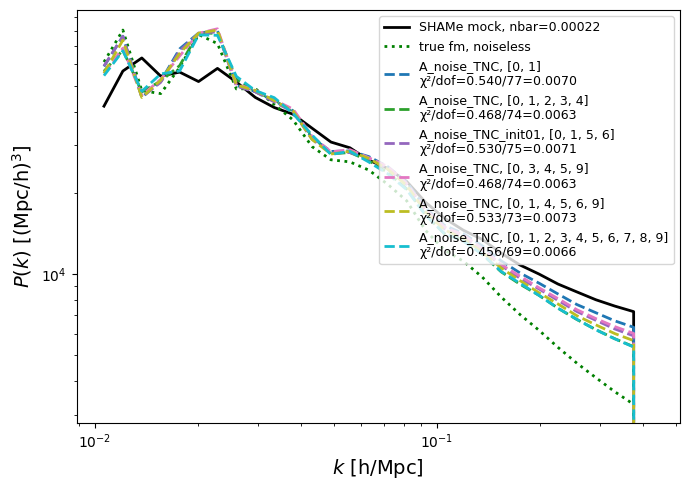

In [25]:
# Plot power spectrum
plt.figure(figsize=(7, 5))

# Plot observed data
label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(k_mock[0], y_mock[0], color='black', label=label, lw=2)

# Plot noiseless model
plt.plot(pk_noiseless['k'], pk_noiseless['pk'], color='green', ls=':', 
         label='true fm, noiseless', lw=2)

# Plot each fitted model
colors = plt.cm.tab10(np.linspace(0, 1, len(loaded_results)))
for i, lr in enumerate(loaded_results):
    result = lr['result']
    pk_obj_model = result.get('pk_obj_model')
    
    if pk_obj_model is not None:
        config_name = result['config']['config_name']
        chi2 = result.get('chi2')
        reduced_chi2 = result.get('reduced_chi2')
        dof = result.get('dof')
        idxs_vary = result.get('idxs_vary')
        
        # Create label with chi^2 info
        if chi2 is not None:
            label_text = f'{config_name}, {idxs_vary}\nχ²/dof={chi2:.3f}/{dof:d}={reduced_chi2:.4f}'
        else:
            label_text = f'{config_name}, {idxs_vary}'
        
        plt.plot(pk_obj_model['k'], pk_obj_model['pk'], color=colors[i], ls='--', 
                 label=label_text, lw=2)

plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=9, loc='upper right')
plt.tight_layout()
plt.show()


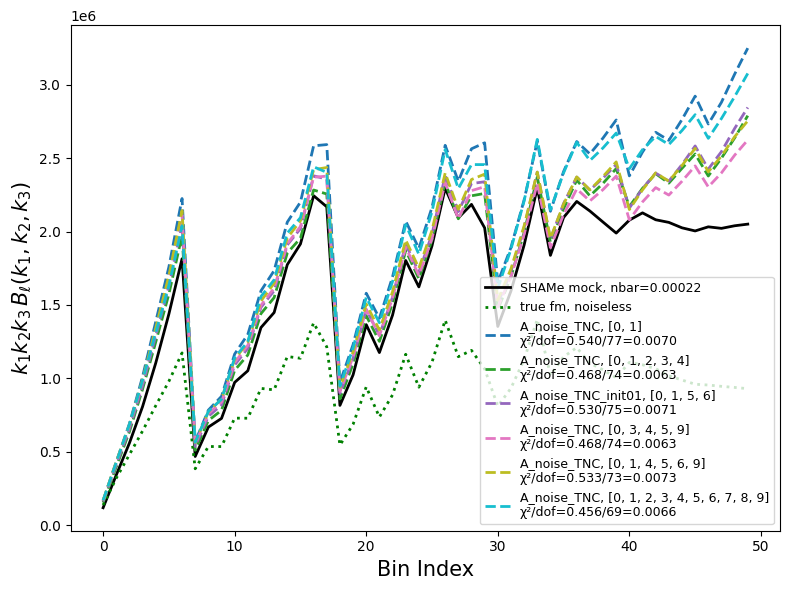

In [26]:
# Plot bispectrum
plt.figure(figsize=(8, 6))

# Plot observed data
label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(y_mock[1], color='black', label=label, lw=2)

# Plot noiseless model
plt.plot(norm**3 * weight * bk_corr_noiseless['b0'], color='green', ls=':', 
         label='true fm, noiseless', lw=2)

# Plot each fitted model
colors = plt.cm.tab10(np.linspace(0, 1, len(loaded_results)))
for i, lr in enumerate(loaded_results):
    result = lr['result']
    
    # Get bispectrum data from bispec_results_dict
    bispec_dict = result.get('bispec_results_dict')
    if bispec_dict is not None:
        bk_corr_model = bispec_dict.get('bispectrum')
        weight_model = bispec_dict.get('weight')
        n_grid_model = bispec_dict.get('n_grid', n_grid)
        # Match original normalization: norm = n_grid**3, then use norm**3
        norm_model = n_grid_model**3
        
        if bk_corr_model is not None:
            config_name = result['config']['config_name']
            chi2 = result.get('chi2')
            reduced_chi2 = result.get('reduced_chi2')
            dof = result.get('dof')
            idxs_vary = result.get('idxs_vary')
            
            # Create label with chi^2 info
            if chi2 is not None:
                label_text = f'{config_name}, {idxs_vary}\nχ²/dof={chi2:.3f}/{dof:d}={reduced_chi2:.4f}'
            else:
                label_text = f'{config_name}, {idxs_vary}'
            
            # Use norm_model**3 to match original normalization (norm = n_grid**3, then norm**3)
            plt.plot(norm_model**3 * weight_model * bk_corr_model['b0'], color=colors[i], ls='--', 
                     label=label_text, lw=2)

plt.xlabel(r'Bin Index', fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=15)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()


## fewer bispec bins?


In [113]:
data_mode = 'muchisimocks'
statistics = ['pk', 'bispec']
#statistics = ['pk']

### train
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n10000'
### test
# tag_params = '_test_p5_n1000'
# tag_biasparams = '_biaszen_p4_n1000'
# tag_noise = '_noise_unit_test_p5_n1000'
# tag_Anoise = '_Anmult_p5_n1000'
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}
tag_mask = '_kmaxbispec0.2'

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_mask + tag_stats + tag_params + tag_biasparams + tag_datagen
k_arr_np5, y_arr_np5, y_err_np5, idxs_params_np5, params_df_np5, param_dict_fixed_np5, biasparams_df_np5, biasparams_dict_fixed_np5, Anoise_df_np5, Anoise_dict_fixed_np5, random_ints_np5, random_ints_bias_np5 = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr_np5[0].shape)
print(y_arr_np5[1].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Found 10000 diff cosmo pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loaded pk data with shape (10000, 30)
fn_mask: ../data/masks/mask_pk_muchisimocks_kmaxbispec0.2_pk_bispec_p5_n10000_biaszen_p4_n10000.txt
Loading from ../data/masks/mask_pk_muchisimocks_kmaxbispec0.2_pk_bispec_p5_n10000_biaszen_p4_n10000.txt (already exists)
Masked 1 out of 30 bins
(29,) (10000, 30) (10000, 30) (30,)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_p5_n10000_biaszen_p4_n10000_nois

In [114]:
k_bispec_np5 = k_arr_np5[statistics.index('bispec')]
y_bispec_np5 = y_arr_np5[statistics.index('bispec')]

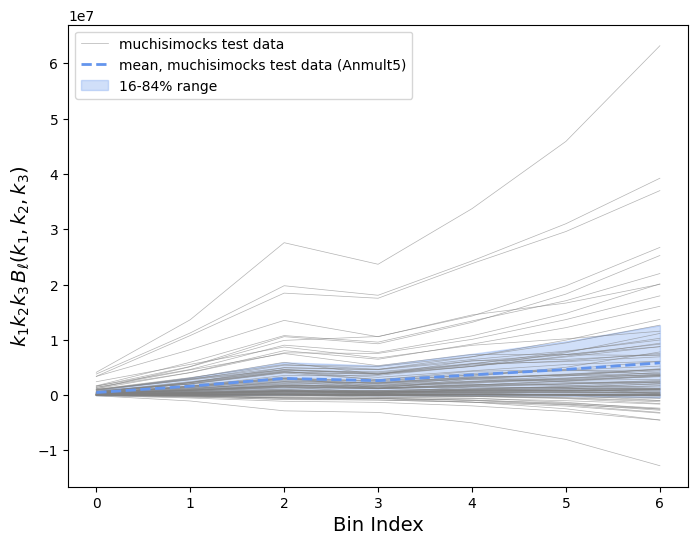

In [115]:
plt.figure(figsize=(8,6))

n_plot = 100
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(range(len(y_bispec_np5[i])), y_bispec_np5  [i], color='grey', alpha=0.6, lw=0.5, label=label)


## Anmult p5
mean = np.mean(y_bispec_np5, axis=0)
p16 = np.percentile(y_bispec_np5, 16, axis=0)
p84 = np.percentile(y_bispec_np5, 84, axis=0)
plt.plot(range(len(mean)), mean, color='cornflowerblue', ls='--', lw=2, label='mean, muchisimocks test data (Anmult5)')
plt.fill_between(range(len(mean)), p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')
plt.plot()

plt.xlabel(r'Bin Index', fontsize=14)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=14)
plt.legend(fontsize=10)
#plt.ylim(p16.min()*2, p84.max()*0.8)